# Regressão Linear Bayesiana
---

A **Regressão Linear Bayesiana**, diferente da regressão linear, visa encontrar uma distribuição de probabilidade que represente os possíveis modelos lineares que representem os dados, ou seja, enquanto a regressão linear busca encontrar um vetor de pesos *w* tal que se aproxime de $y - w^{T}x \approx 0$ , a regressão linear bayesiana busca encontrar $p(w) = \mathcal{N}(w|\mu,\sigma^2)$ que também se aproxime.

As implementações feitas neste notebook têm como base as explicações da seguinte [explicação](http://krasserm.github.io/2019/02/23/bayesian-linear-regression/). Entretanto, para melhor entendimento do conteúdo, todo o código foi reescrito e comentado

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [8]:
# funções auxiliares de plot
def plot_data(x,y):
    plt.scatter(x,y,marker='o',c='k',s=20)
    
def plot_expected(x,y, label=True):
    if label:
        plt.plot(x,y,'k--',label="Valor esperado")
    else: 
        plt.plot(x,y,'k--')

def plot_prediction(x,y,var, std_times=1):
    y = y.ravel() #flatten
    std = np.sqrt(var.ravel()) * std_times #flatten
    
    plt.plot(x,y, label="Predição")
    plt.fill_between(x.ravel(), y+std, y-std, alpha=.5, label="Incerteza")
    
def plot_model(x,y, label=False):
    if label:
        plt.plot(x, y, 'r--', alpha=.5, label="Modelos a posteriori")
    else: 
        plt.plot(x, y, 'r--', alpha=.5)
    
def plot_models(x, ys):
    plot_model(x,ys[:,0], label=True)
    for i in range(1, ys.shape[1]):
        plot_model(x,ys[:,i])
        
def plot_posteriori_distribution(mean, cov, w0, w1, resolution=100):
    x = y = np.linspace(-1,1,resolution)
    
    grid = np.dstack(np.meshgrid(x,y)).reshape(-1,2)
    densities = multivariate_normal.pdf(grid, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    print(densities)
    plt.imshow(densities, origin='lower', extent=(-1,1,-1,1))
    plt.scatter(w0,w1, marker='x', c='r', s=20, label="Pesos esperados")

Para este exemplo, a função que desejamos encontrar é $$f(x) = 0.5x - 0.3$$

In [4]:
f_w0 = -0.3
f_w1 =  0.5

def noise(size, variance):
    '''Gera uma matriz com ruidos normalizados, com média 0 e a variância informada'''
    return np.random.normal(scale=np.sqrt(variance), size=size)

def f(x, noise_variance):
    '''Aplica a função f em X, adicionando um ruído normal com média 0 e variância informada'''
    return f_w0 + f_w1 * x + noise(x.shape, noise_variance)

def add_bias_parameter(x):
    '''Adiciona os termos independentes (parâmetro bias) aos dados'''
    return np.concatenate([np.ones(x.shape), x], axis=1)

Assim como na regressão linear, vamos assumir valores iniciais para *w* (no caso, uma distribuição inicial). Essa *distribuição a priori* de *w* será, por convenção, uma distribuição com média 0 e com uma precisão $\alpha$, tal que
$$p(w|\alpha) = \mathcal{N}(w|\alpha^{⁻1}I)$$

Após N amostras, com entrada $\Phi$ e saídas ***y***, a distribuição de *w* continua sendo uma normal, onde:

* sua média é $m_N = S_N(S_0^{-1}m_0 + \beta \Phi^{T}y)$. Como a distribuição a priori de *w* tem média 0, a fórmula simplifica para $m_N = \beta S_n\Phi^{T}y$

* a matriz inversa de sua variância é $S_N^{-1} = S_0^{-1} + \beta \Phi^T \Phi$. Como $S_0 = \alpha^{⁻1}I$, $S_0^{-1} = \alpha I$. Portanto, a fórmula da inversa da variância fica $S_N^{-1} = \alpha I + \beta \Phi^T \Phi$

Agora que temos a distribuição a posteriori de w $p(w| x,\textbf{y}, \alpha, \beta) = \mathcal{N}(w|m_N, S_N)$, podemos encontrar as distribuições preditivas $p(t| x,\textbf{y}, \alpha, \beta) = \mathcal{N}(t|m_N^T \Phi(x), \sigma_N^2(x))$, onde $\sigma_N^2(x) = \frac{1}{\beta} + \Phi(x)^T S_N \Phi(x)$

In [5]:
def posteriori(x, y, alpha, beta):
    '''p(w|t) = N(w|mean,var)'''
    var_inv = alpha*np.eye(x.shape[1]) + beta*x.T.dot(x) # var_inv = alpha * I + beta * xT * x
    var = np.linalg.inv(var_inv) # var_inv_inv
    mean = beta * var.dot(x.T).dot(y) # var * ( var_0_inv * mean_0 + beta * xT * y ), onde mean_0 = 0
    
    return mean, var

def predict(x, mean, var, beta):
    '''Como w segue uma distribuição normal, o valor mais provável de w será a esperança da distribuição,
    que, no caso da normal, é a média. Logo:
    y = x * mean
    '''
    y = x.dot(mean)
    var = (1 / beta) + np.sum(x.dot(var) * x, axis = 1)
    
    return y, var

Para estes exemplos, vamos utilizar $\Phi(x) = x$, para simplificar. Vamos gerar 20 amostras ao todo, porêm vamos analizar o treinamento com 1, 3 e 20 amostras.

As amostras serão geradas aleatoriamentes, seguindo uma distribuição normal. Para as saídas, aplicaremos a função *f(x)* apresentada anteriormente e adicionaremos um ruído que segue uma distribuição normal de variância $\frac{1}{\beta}$.

Para testar os modelos, iremos pegar 100 valores dentro do intervalo das amostras geradas e suas saídas serão calculadas sem ruído.

In [6]:
# tamanho das amostras para os exemplos
samples_sizes = [1, 3, 20]
# número de experimentos, baseado na quantidade de exemplos
n_experiments = len(samples_sizes)

# hiperparâmetros para precisão
alpha = 2 # precisão inicial
beta = 25 # precisão após a análise

# geração dos dados de treino
X = np.random.randn(max(samples_sizes), 1) # distribuição normal, com max(samples_sizes) amostras e 1 atributo
Y = f(X, noise_variance=1/beta) # valores de saída com um ruído com precisão beta

# geração dos dados de teste
X_test = np.linspace(min(X), max(X), 100).reshape(-1,1) # 100 valores no intervalo dos gerados em X, para gerar uma retasobre todo o eixo x
phi_test = add_bias_parameter(X_test) # matriz de dados de teste, com o parâmetro bias
Y_test = f(X_test, noise_variance=0) # valores de saída para o teste, sem ruído

[[2.73180323e-40 1.09576004e-39 4.34706250e-39 ... 4.69284400e-04
  6.46394406e-04 8.80589387e-04]
 [2.45609084e-39 9.69197176e-39 3.78263329e-38 ... 8.64357449e-04
  1.17126866e-03 1.56976287e-03]
 [2.14938374e-38 8.34417392e-38 3.20381272e-37 ... 1.54961983e-03
  2.06580813e-03 2.72376218e-03]
 ...
 [2.29482752e-02 1.88572493e-02 1.53257248e-02 ... 6.42059233e-33
  1.81175229e-33 5.05634766e-34]
 [1.50374400e-02 1.21563689e-02 9.71959623e-03 ... 8.61908578e-34
  2.39269090e-34 6.56941019e-35]
 [9.59118543e-03 7.62788129e-03 5.99998203e-03 ... 1.12621637e-34
  3.07573492e-35 8.30788272e-36]]
[[6.24057904e-54 4.98520313e-53 3.85916162e-52 ... 6.15460557e-30
  2.33246713e-30 8.56609681e-31]
 [1.07737007e-52 8.47471070e-52 6.46006659e-51 ... 2.38031668e-29
  8.88284437e-30 3.21233998e-30]
 [1.79023496e-51 1.38666647e-50 1.04084518e-49 ... 8.86082924e-29
  3.25606964e-29 1.15948502e-29]
 ...
 [3.40413712e-11 6.09199466e-11 1.05648691e-10 ... 3.19557232e-50
  2.71305411e-51 2.23213470e-52]

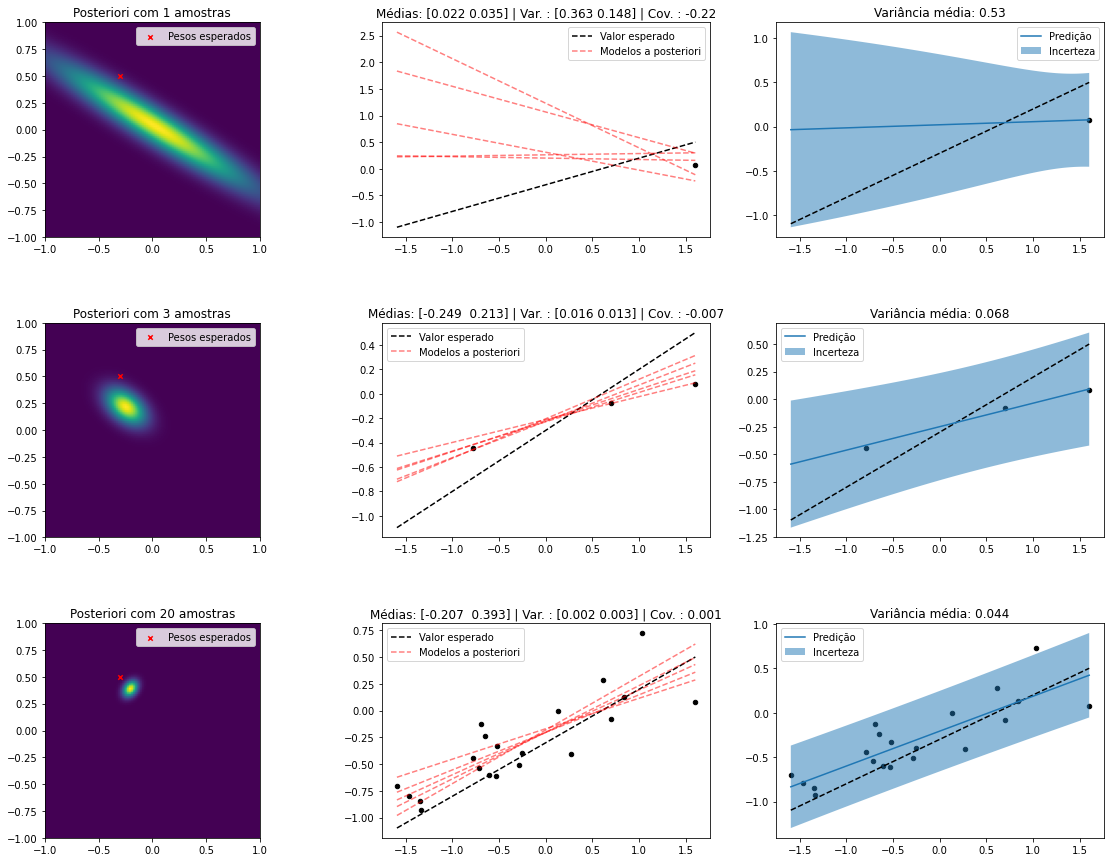

In [9]:
plt.figure(figsize=(20,15))
plt.subplots_adjust(hspace=.4)

for i, n in enumerate(samples_sizes):
    # obtendo os elementos da amostra
    x_n = X[:n] # dados de treino
    phi_n = add_bias_parameter(x_n) # dados de treino com parâmetro bias 
    y_n = Y[:n] # valores de saída
    
    # treinando o modelo
    mean, var = posteriori(phi_n, y_n, alpha, beta) # computando a posteriori de w
    y, y_var = predict(phi_test, mean, var, beta) # prevendo valores para Y, dado os parâmetros da distribuição de w
    
    # obtendo 5 exemplos de modelo a partir da distribuição de w
    models_samples = np.random.multivariate_normal(mean.ravel(), var, 5).T # como w segue uma distribuição normal, os modelos gerados aleatoriamente seguind oessa distruibuição representam bem os dados
    prediction_samples = phi_test.dot(models_samples) # realizando a predição de Y utilizando os modelos 
    
    # plots
    plt.subplot(n_experiments, 3, i*3 + 1)
    plot_posteriori_distribution(mean, var, f_w0, f_w1) # distribuição posteriori dos pesos a partir das amostras
    plt.title(f"Posteriori com {n} amostras")
    plt.legend()
    
    plt.subplot(n_experiments, 3, i*3 + 2)
    plot_data(x_n, y_n) # valores utilizados para o treinamento do modelo
    plot_expected(X_test, Y_test) # valores esperados para a predição
    plot_models(X_test, prediction_samples) # valores preditos pelos modelos que seguem a distribuição calculada
    var_string = str(np.diag(np.round(var, 3)))
    plt.title(f"Médias: {np.round(mean.ravel(), 3)} | Var. : {var_string} | Cov. : {np.round(var[0,1], 3)}")
    plt.legend()    
    
    plt.subplot(n_experiments, 3, i*3 + 3)
    plot_data(x_n, y_n) # valores utilizados para o treinamento do modelo
    plot_expected(X_test, Y_test, label=False) # valores esperados para a predição
    plot_prediction(X_test, y, np.sqrt(y_var), std_times=1) # valores predito pela esperança da distribuição de w
    plt.title(f"Variância média: {np.round(np.mean(y_var), 3)}")
    plt.legend()